# Sea ice concentration in AABW formation regions

In [32]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import matplotlib.path as mpath
import os.path
from datetime import timedelta

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter
import matplotlib.ticker as mticker
import calendar

In [33]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35557/status,
Dashboard: /proxy/35557/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37901,Workers: 7
Dashboard: /proxy/35557/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:46505,Total threads: 4
Dashboard: /proxy/34867/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:38319,


In [5]:
path_output = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'
start_time = '2001-01-01'
end_time = '2005-12-31'
session = cc.database.create_session()

In [6]:
exptdict = OrderedDict([
    ('panan_01deg', # 1/10th panantarctic zstar run
     {'expt': 'panant-01-zstar-ACCESSyr2',
      'expt_name': 'panan_01deg_jra55_ryf',
      'expt_str': '1/10°'}),
    ('panan_005deg', # 1/20th panantarctic zstar run
     {'expt': 'panant-005-zstar-ACCESSyr2',
      'expt_name': 'panan_005deg_jra55_ryf',
      'expt_str': '1/20°'}),
    ('panan_0025deg', # 1/40th panantarctic zstar run
     {'expt': 'panant-0025-zstar-ACCESSyr2',
      'expt_name': 'panan_0025deg_jra55_ryf',
      'expt_str': '1/40°'})
])

In [7]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'sector': [[-65, 0, -78.5,  -62],
               [45, 80, -70, -60],
               [125-360, 165-360, -70, -60],
               [150-360, 220-360, -79, -65]],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'contour_depth': [650, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}

In [46]:
%%time
ekeys = ['panan_01deg', 'panan_005deg']
for ekey in ekeys:
    e = exptdict[ekey]

    e['area_open_water'] = xr.open_dataarray(
        path_output + 'area_open_water_spatial_sum_in_each_AABW_formation_region_' +
        e['expt_name'] + '_1m_' + start_time[:4] + '-' + end_time[:4] + '.nc')

CPU times: user 25.2 ms, sys: 5.93 ms, total: 31.1 ms
Wall time: 31.6 ms


In [14]:
def mask_from_polygon(lon, lat, xh, yh):
    polygon = [(lon[0], lat[0])]
    for l in range(1, len(lon)):
        polygon += [(lon[l], lat[l])]
    poly_path = mpath.Path(polygon)

    x, y = xr.broadcast(xh, yh)
    coors = np.hstack((x.values.reshape(-1, 1), y.values.reshape(-1, 1)))

    mask = poly_path.contains_points(coors)
    mask = mask.reshape(xh.size, yh.size).transpose()
    mask = xr.DataArray(
        mask, dims=['yh', 'xh'], coords={'xh': xh, 'yh': yh})
    return mask

In [15]:
def shelf_mask_isobath(var, contour_depth, resolution, output_mask=False):
    '''
    Masks varibales by the region polewards of a given isobath
    '''
    
    ds_contour = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
        'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' +
        resolution + 'deg.nc')
    
    shelf_mask = ds_contour.contour_masked_above.sel(yh=slice(var.yh[0], var.yh[-1]))
    yh = ds_contour.yh.sel(yh=slice(var.yh[0], var.yh[-1]))
    xh = ds_contour.xh
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask = shelf_mask.where(shelf_mask == 0)+1
    shelf_mask = shelf_mask.where(shelf_mask == 1, 0)
    
    # multiply the variable with the mask
    masked_var = var * shelf_mask
    
    if output_mask == True:
        return masked_var, shelf_mask
    else:
        return masked_var

In [35]:
ekey = 'panan_005deg'
e = exptdict[ekey]
resolution = e['expt_name'].split('_')[1][:-3]

In [36]:
depth = cc.querying.getvar(
    e['expt'], 'deptho', session, n=1,
    chunks={'xh': '100MB', 'yh': '100MB'})
land_mask = (depth*0).fillna(1)

area = cc.querying.getvar(
    e['expt'], 'areacello', session, n=1,
    chunks={'xh': '100MB', 'yh': '100MB'})
xh = area.xh
yh = area.yh

for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        mask_DSW = mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a], xh, yh).expand_dims(
            area=['Weddell'])
    else:
        mask_DSW = xr.concat((mask_DSW, mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a], xh, yh).expand_dims(
            area=[area_text])), dim='area')
    mask_DSW = shelf_mask_isobath(mask_DSW, contour_depth=1000, resolution=resolution)
mask_DSW = mask_DSW.where(mask_DSW == True)
mask_DSW = mask_DSW.where(land_mask == 0)
mask_DSW = mask_DSW .where(mask_DSW == 1, 0)

area_mask_DSW = mask_DSW * area * (land_mask.where(land_mask == 0)+1)

In [11]:
%%time
# Cut out sea ice concentration in sectors of AABW formation at daily resolution and save.
# This takes about 1 hour
filename = ('sea_ice_concentration_Ross_' + e['expt_name'] + '_1d_' +
            start_time[:4] + '-' + end_time[:4] + '.nc')
if os.path.exists(path_output + filename) is False:
    for a, area_text in enumerate(DSW_region['name']):
        print(a)
        ice_conc = cc.querying.getvar(
            e['expt'], 'siconc', session, frequency='1 daily',
            start_time=start_time, end_time=end_time,
            chunks={'xT': '200MB', 'yT': '200MB'}).sel(
            time=slice(start_time, end_time), yT=slice(None, -60)).rename(
            {'xT': 'xh', 'yT': 'yh'})
        ice_conc = ice_conc.sel(
            xh=slice(DSW_region['sector'][a][0], DSW_region['sector'][a][1]),
            yh=slice(DSW_region['sector'][a][2], DSW_region['sector'][a][3])).compute()
        ice_conc = ice_conc.assign_coords({'area': area_text})
        filename = ('sea_ice_concentration_' + area_text + '_' + e['expt_name'] + '_1d_' +
                    start_time[:4] + '-' + end_time[:4] + '.nc')
        enc = {'siconc': {'chunksizes': (365, 200, 200),
                        'zlib': True, 'complevel': 5, 'shuffle': True}}
        ice_conc.to_netcdf(path_output + filename, encoding=enc)

0
1
2
3
CPU times: user 6min 51s, sys: 1min, total: 7min 51s
Wall time: 11min 25s


In [37]:
%%time
# area of open water at monthly resolution
for a, area_text in enumerate(DSW_region['name']):
    ice_conc = xr.open_dataarray(
        path_output + 'sea_ice_concentration_' + area_text + '_' + e['expt_name'] +
        '_1d_' + start_time[:4] + '-' + end_time[:4] + '.nc',
        chunks={'time': '200MB'})
    if a == 0:
        area_open_water = ((1-ice_conc) * area_mask_DSW[a, :]).sum(
            ['xh', 'yh'])
        area_open_water_m = area_open_water.resample(
            time='M', label='left', loffset=timedelta(days=15)).mean().compute()
    else:
        area_open_water = ((1-ice_conc) * area_mask_DSW[a, :]).sum(
            ['xh', 'yh'])
        area_open_water_m = xr.concat(
            (area_open_water_m, area_open_water.resample(
            time='M', label='left', loffset=timedelta(days=15)).mean().compute()),
            dim='area')
area_open_water_m = area_open_water_m
area_open_water_m.name = 'area_open_water'
area_open_water_m.attrs = {
    'units': 'm2',
     'time_average': 'monthly mean of area where sea ice concentration is 0%'}
enc = {'area_open_water': {'zlib': True, 'complevel': 5, 'shuffle': True}}
area_open_water_m.to_netcdf(
    path_output + 'area_open_water_spatial_sum_in_each_AABW_formation_region_' +
    e['expt_name'] + '_1m_' + start_time[:4] + '-' + end_time[:4] + '.nc',
    encoding=enc)

CPU times: user 29.8 s, sys: 4.59 s, total: 34.4 s
Wall time: 2min 32s


### Plots

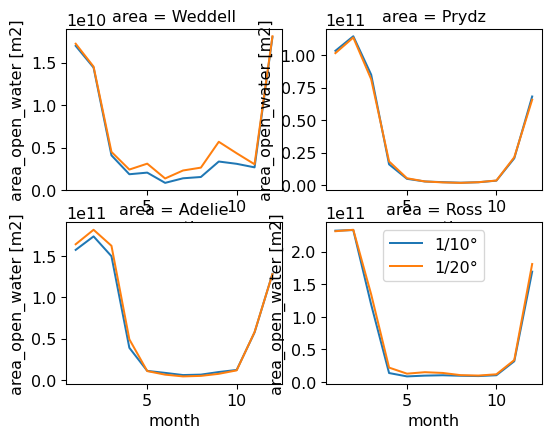

In [50]:
for a in range(4):
    plt.subplot(2, 2, a+1)
    for ekey in ekeys:
        e = exptdict[ekey]
        e['area_open_water'][a, :].groupby('time.month').mean().plot(label=e['expt_str'])
plt.legend()

## To do

Maps of sea ice thickness

compare area with no and thin ice (< ?? cm)